INSTALLING NECESSARY LIBRARIES

In [25]:
!pip install thefuzz
!pip install plotly
!pip install openpyxl

Importing all required libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


Text processing & fuzzy matching

In [27]:
from thefuzz import process, fuzz

General

In [29]:
import re
import warnings
warnings.filterwarnings('ignore')

print(" All libraries installed and imported successfully!")

 All libraries installed and imported successfully!


 Load dataset from Google Sheets

In [30]:
sheet_url = 'https://docs.google.com/spreadsheets/d/12JWizEwTPYgXOmh_762iy-Q5694zxhlO/export?format=csv&gid=2004884327'
usecols = [
    'Title', 'URL', 'City', 'Type', 'Area', 'Price', 'Purpose',
    'Location', 'Description', 'Built in year', 'Bedrooms', 'Bathrooms', 'Parking Spaces'
]

df = pd.read_csv(sheet_url, usecols=usecols)

print(" Data loaded successfully!")
print("Shape:", df.shape)
df.head()

 Data loaded successfully!
Shape: (18255, 13)


,Title,URL,City,Type,Area,Price,Purpose,Location,Description,Built in year,Parking Spaces,Bedrooms,Bathrooms
0,Hmr Waterfront 2 Bed Room Premium Apartment On...,https://www.zameen.com/Property/dha_phase_8_hm...,Karachi,Flat,128 Sq. Yd.,PKR\n4.75 Crore,For Sale,"DHA Defence, Karachi, Sindh",SAIMA MARINA RESIDENCE HMR WATERFRONT\nINVESTO...,NaN,NaN,2,2
1,Chance Deal! Luxury 2 Bedroom Seafront Apartme...,https://www.zameen.com/Property/dha_defence_dh...,Karachi,Flat,161 Sq. Yd.,PKR\n6.25 Crore,For Sale,"DHA Defence, Karachi, Sindh",Live the Seafront Dream at H&S Residence \n2 B...,NaN,NaN,2,3
2,Luxury 1 Bed At H& S Residence By Japanese Arc...,https://www.zameen.com/Property/dha_phase_8_hm...,Karachi,Flat,111 Sq. Yd.,PKR\n3.45 Crore,For Sale,"DHA Defence, Karachi, Sindh",Live the Seafront Dream at H&S Residence \n1 B...,NaN,NaN,1,2
3,Luxury 1 Bed Seafront Apartment at HMR waterfr...,https://www.zameen.com/Property/dha_phase_8_hm...,Karachi,Flat,106 Sq. Yd.,PKR\n2.98 Crore,For Sale,"DHA Defence, Karachi, Sindh",Chance Deal at HMR Waterfront 1-Bed Apartment ...,2.0,1.0,1,2
4,2 Bed Apartment For Booking On 3 Years | Saima...,https://www.zameen.com/Property/dha_phase_8_hm...,Karachi,Flat,156 Sq. Yd.,PKR\n4.65 Crore,For Sale,"DHA Defence, Karachi, Sindh",HMR WATERFRONT \n\nOwn Your Dream Apartment in...,NaN,NaN,2,2


In [31]:


import re
import numpy as np
import pandas as pd

# ---------- PRICE CLEANING ----------
def clean_price(price_str):
    if pd.isna(price_str):
        return np.nan
    price_str = str(price_str).replace('PKR', '').replace('\n', '').replace(',', '').strip()

    if 'Crore' in price_str:
        num = float(re.findall(r"[0-9]*\.?[0-9]+", price_str)[0]) * 1e7
    elif 'Lakh' in price_str:
        num = float(re.findall(r"[0-9]*\.?[0-9]+", price_str)[0]) * 1e5
    else:
        nums = re.findall(r"[0-9]*\.?[0-9]+", price_str)
        num = float(nums[0]) if nums else np.nan
    return num

df['Price_Cleaned'] = df['Price'].apply(clean_price)

# ---------- AREA CLEANING ----------
def convert_area(area_str):
    if pd.isna(area_str):
        return np.nan
    area_str = str(area_str).strip()
    nums = re.findall(r"[0-9]*\.?[0-9]+", area_str)
    value = float(nums[0]) if nums else np.nan

    if 'Sq. Yd' in area_str:
        return value * 9  # Convert to sqft
    elif 'Sq. Ft' in area_str:
        return value
    elif 'Marla' in area_str:
        return value * 272.25
    elif 'Kanal' in area_str:
        return value * 5445
    return value

df['Area_Sqft'] = df['Area'].apply(convert_area)

# ---------- FIX COLUMN TYPES ----------
numeric_cols = ['Bedrooms', 'Bathrooms']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# ---------- MISSING VALUES ----------
for col in numeric_cols:
    df[col].fillna(df[col].median(), inplace=True)

# ---------- FEATURE ENGINEERING ----------
df['Price_per_sqft'] = df['Price_Cleaned'] / df['Area_Sqft']

print("✅ Data cleaned successfully!")
df[['City', 'Type', 'Area', 'Area_Sqft', 'Price', 'Price_Cleaned', 'Bedrooms', 'Bathrooms', 'Price_per_sqft']].head()


✅ Data cleaned successfully!


,City,Type,Area,Area_Sqft,Price,Price_Cleaned,Bedrooms,Bathrooms,Price_per_sqft
0,Karachi,Flat,128 Sq. Yd.,1152.0,PKR\n4.75 Crore,47500000.0,2.0,2.0,41232.638889
1,Karachi,Flat,161 Sq. Yd.,1449.0,PKR\n6.25 Crore,62500000.0,2.0,3.0,43133.195307
2,Karachi,Flat,111 Sq. Yd.,999.0,PKR\n3.45 Crore,34500000.0,1.0,2.0,34534.534535
3,Karachi,Flat,106 Sq. Yd.,954.0,PKR\n2.98 Crore,29800000.0,1.0,2.0,31236.897275
4,Karachi,Flat,156 Sq. Yd.,1404.0,PKR\n4.65 Crore,46500000.0,2.0,2.0,33119.658120


In [32]:
import re
import numpy as np
import pandas as pd

# Function to clean and convert price text to numeric PKR
def clean_price(price):
    if pd.isna(price):
        return np.nan
    price = str(price).replace('\n', ' ').replace(',', '').strip().upper()

    # Handle crore, lakh, arab, million, thousand
    if 'CRORE' in price:
        num = re.findall(r"[\d\.]+", price)
        return float(num[0]) * 1e7 if num else np.nan
    elif 'LAKH' in price:
        num = re.findall(r"[\d\.]+", price)
        return float(num[0]) * 1e5 if num else np.nan
    elif 'ARAB' in price:
        num = re.findall(r"[\d\.]+", price)
        return float(num[0]) * 1e9 if num else np.nan
    elif 'MILLION' in price:
        num = re.findall(r"[\d\.]+", price)
        return float(num[0]) * 1e6 if num else np.nan
    elif 'THOUSAND' in price:
        num = re.findall(r"[\d\.]+", price)
        return float(num[0]) * 1e3 if num else np.nan
    else:
        # If only digits are present
        num = re.findall(r"[\d\.]+", price)
        return float(num[0]) if num else np.nan

# Apply cleaning function and store cleaned prices
df['Price_Cleaned'] = df['Price'].apply(clean_price)

# For consistency, let's overwrite the old Price column too
df['Price'] = df['Price_Cleaned']

# Drop the temporary column (optional)
df.drop(columns=['Price_Cleaned'], inplace=True)

# Verify that prices are now numeric
print(df[['City', 'Type', 'Area', 'Price']].head())

# Confirm column type
print("\nColumn type of 'Price':", df['Price'].dtype)



      City  Type         Area       Price
0  Karachi  Flat  128 Sq. Yd.  47500000.0
1  Karachi  Flat  161 Sq. Yd.  62500000.0
2  Karachi  Flat  111 Sq. Yd.  34500000.0
3  Karachi  Flat  106 Sq. Yd.  29800000.0
4  Karachi  Flat  156 Sq. Yd.  46500000.0

Column type of 'Price': float64


In [33]:
# --- STEP 4 : DATA CLEANING & CONSISTENCY ---
!pip install -q rapidfuzz

import pandas as pd
from rapidfuzz import process, fuzz
import numpy as np

# ---------- STANDARDIZE CITY NAMES ----------
valid_cities = ['Karachi', 'Lahore', 'Islamabad', 'Rawalpindi', 'Peshawar', 'Faisalabad', 'Multan', 'Hyderabad']

def standardize_city(city):
    if pd.isna(city):
        return np.nan
    match, score, _ = process.extractOne(city, valid_cities, scorer=fuzz.token_sort_ratio)
    return match if score > 80 else city

df['City'] = df['City'].apply(standardize_city)

# ---------- STANDARDIZE PROPERTY TYPES ----------
df['Type'] = df['Type'].astype(str).str.strip().str.title()

# ---------- ENSURE NUMERIC COLUMNS ----------
# Clean Area column (remove non-numeric text like "Sq. Yd.")
df['Area'] = df['Area'].astype(str).str.replace('[^0-9\.]', '', regex=True)
df['Area'] = pd.to_numeric(df['Area'], errors='coerce')

# Ensure Price column is numeric (should already be from Step 2)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# ---------- REMOVE OUTLIERS USING IQR ----------
numeric_cols = ['Price', 'Area']

for col in numeric_cols:
    # Drop rows with NaN before calculating quantiles
    df = df.dropna(subset=[col])
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_limit) & (df[col] <= upper_limit)]

# ---------- RESET INDEX ----------
df.reset_index(drop=True, inplace=True)

print(" Data standardized, numeric columns cleaned, and outliers removed.")
print("Remaining records:", len(df))
print("\nUnique Cities:", df['City'].unique())
print("\nProperty Types:", df['Type'].unique())


 Data standardized, numeric columns cleaned, and outliers removed.
Remaining records: 14421

Unique Cities: ['Islamabad' 'Faisalabad' 'Multan' 'Rawalpindi' 'Peshawar' 'Jhelum'
 'Murree' 'Bahawalpur' 'Sialkot' 'Abbottabad' 'Sahiwal' 'Lahore' 'Gujrat'
 'Wah' 'Sargodha' 'Sheikhupura' 'Chakwal' 'Nowshera' 'Mardan' 'Chilas'
 'Sarai Alamgir' 'Quetta' 'Rahim Yar Khan' 'Okara' 'Attock'
 'Dera Ghazi Khan' 'Taxila' 'Gwadar' 'Kasur' 'Mirpur' 'Haripur'
 'Gujar Khan' 'Swat' 'Daska' 'Sadiqabad' 'Buner' 'Jhang' 'Lalamusa'
 'Lodhran' 'Pakpattan' 'Chiniot' 'Dera Ismail Khan' 'Fateh Jang'
 'Burewala' 'Hafizabad' 'Talagang' 'Vehari' 'Galyat' 'Gujranwala'
 'Kharian' 'Gujranwala ' 'Jhelum ' 'Sialkot  ' 'Murree ' 'Bahawalpur '
 'Abbottabad ' 'Wah ' 'Gujrat ' 'Sahiwal ' 'Sheikhupura ' 'Sargodha '
 'Rahim Yar Khan ' 'Taxila ' 'Mardan ' 'Sarai Alamgir ' 'Nowshera '
 'Okara ' 'Attock ' 'Dera Ghazi Khan ']

Property Types: ['Flat' 'House' 'Farm House' 'Penthouse' 'Room' 'Lower Portion'
 'Upper Portion']


In [34]:
# --- STEP 5: FEATURE ENGINEERING ---

import numpy as np
import pandas as pd

# Convert Area from Sq. Yards to Sq. Ft. (1 Sq. Yd. = 9 Sq. Ft.)
df['Area_sqft'] = df['Area'] * 9

# Create derived metrics
df['Price_per_sqft'] = df['Price'] / df['Area_sqft']
df['Price_per_bedroom'] = df['Price'] / df['Bedrooms']
df['Area_per_bedroom'] = df['Area_sqft'] / df['Bedrooms']

# Extract main neighborhood from location (before first comma)
def extract_neighborhood(location):
    if pd.isna(location):
        return np.nan
    return location.split(',')[0].strip()

df['Neighborhood'] = df['Location'].apply(extract_neighborhood)

# Replace inf and NaN values (for rows where bedrooms=0 or missing)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.median(numeric_only=True), inplace=True)

print(" Feature engineering complete.")
print("\nPreview of new columns:")
print(df[['City', 'Type', 'Price', 'Area_sqft', 'Price_per_sqft', 'Price_per_bedroom', 'Neighborhood']].head())


 Feature engineering complete.

Preview of new columns:
        City   Type       Price  Area_sqft  Price_per_sqft  Price_per_bedroom  \
0  Islamabad   Flat  55000000.0       63.9    8.607199e+05       1.833333e+07   
1  Islamabad   Flat  52000000.0       27.0    1.925926e+06       1.300000e+07   
2  Islamabad  House  14800000.0       72.0    2.055556e+05       4.933333e+06   
3  Islamabad  House  46500000.0       90.0    5.166667e+05       9.300000e+06   
4  Islamabad  House  48000000.0       90.0    5.333333e+05       9.600000e+06   

         Neighborhood  
0  Diplomatic Enclave  
1                 F-8  
2         DHA Defence  
3         Bahria Town  
4         Bahria Town  


Dataset Summary:

               Area         Price  Built in year  Parking Spaces  \
count  14421.000000  1.442100e+04   14421.000000    14421.000000   
mean       6.166708  1.775066e+07    1996.371091        3.782102   
std        3.604374  2.007798e+07    1749.525257       29.118311   
min        0.000000  6.000000e+03       0.000000        0.000000   
25%        4.000000  1.200000e+05    2023.000000        2.000000   
50%        5.000000  1.350000e+07    2024.000000        2.000000   
75%       10.000000  2.850000e+07    2024.000000        2.000000   
max       19.000000  8.600000e+07  202122.000000     1111.000000   

           Bedrooms     Bathrooms     Area_Sqft  Price_per_sqft     Area_sqft  \
count  14421.000000  14421.000000  14421.000000    1.442100e+04  14421.000000   
mean       4.062756      4.383885   2679.073284    5.585803e+05     55.500374   
std        1.596420      1.549928   2875.996441    1.460436e+06     32.439370   
min        1.000000      1.000000      0.0000

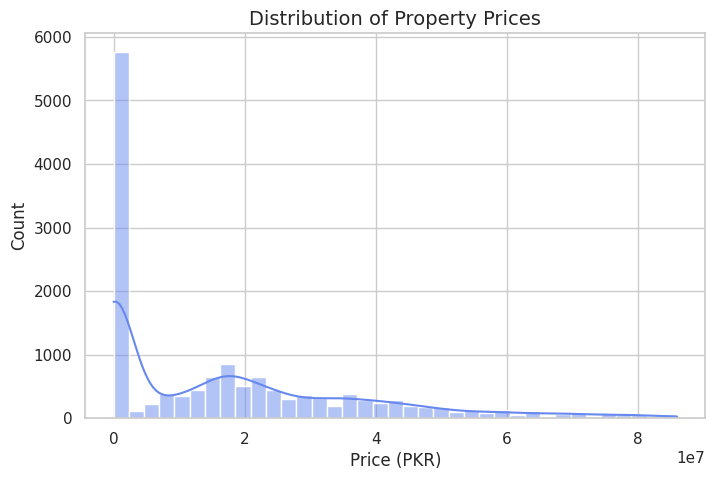

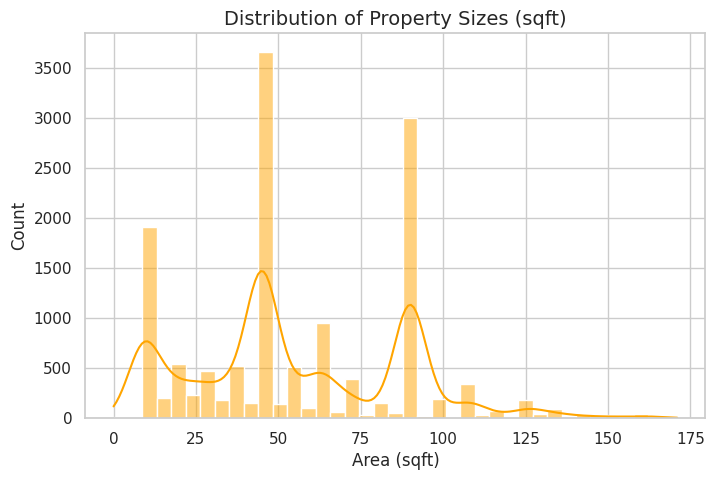

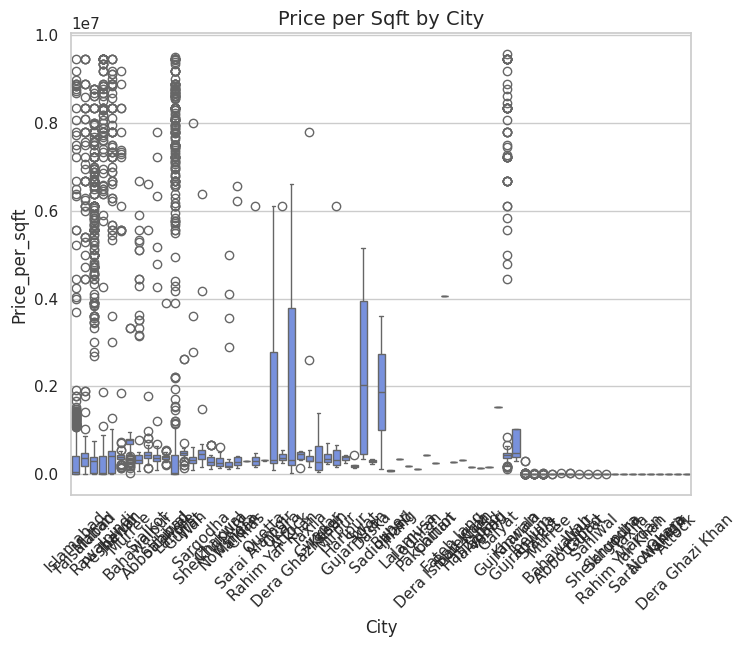

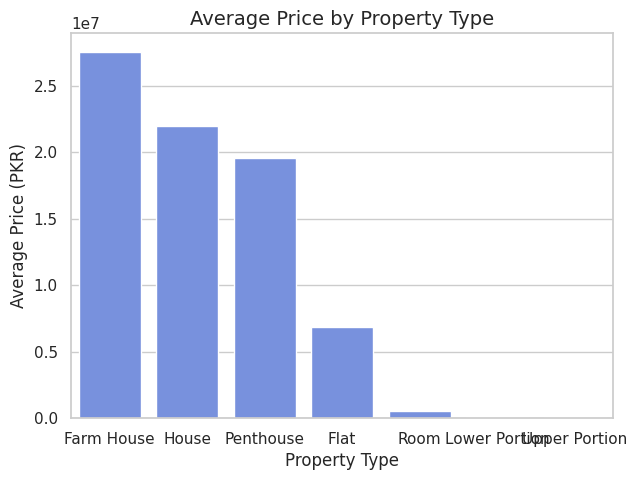

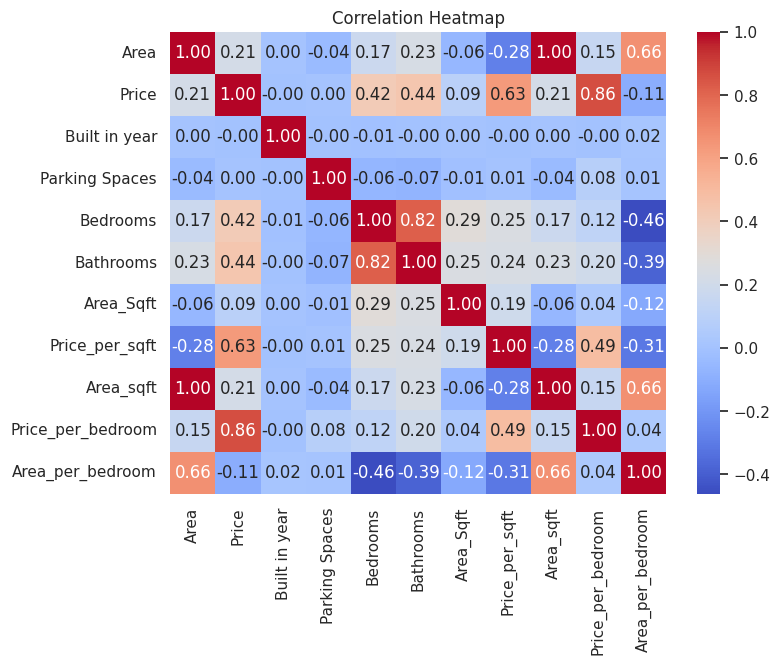

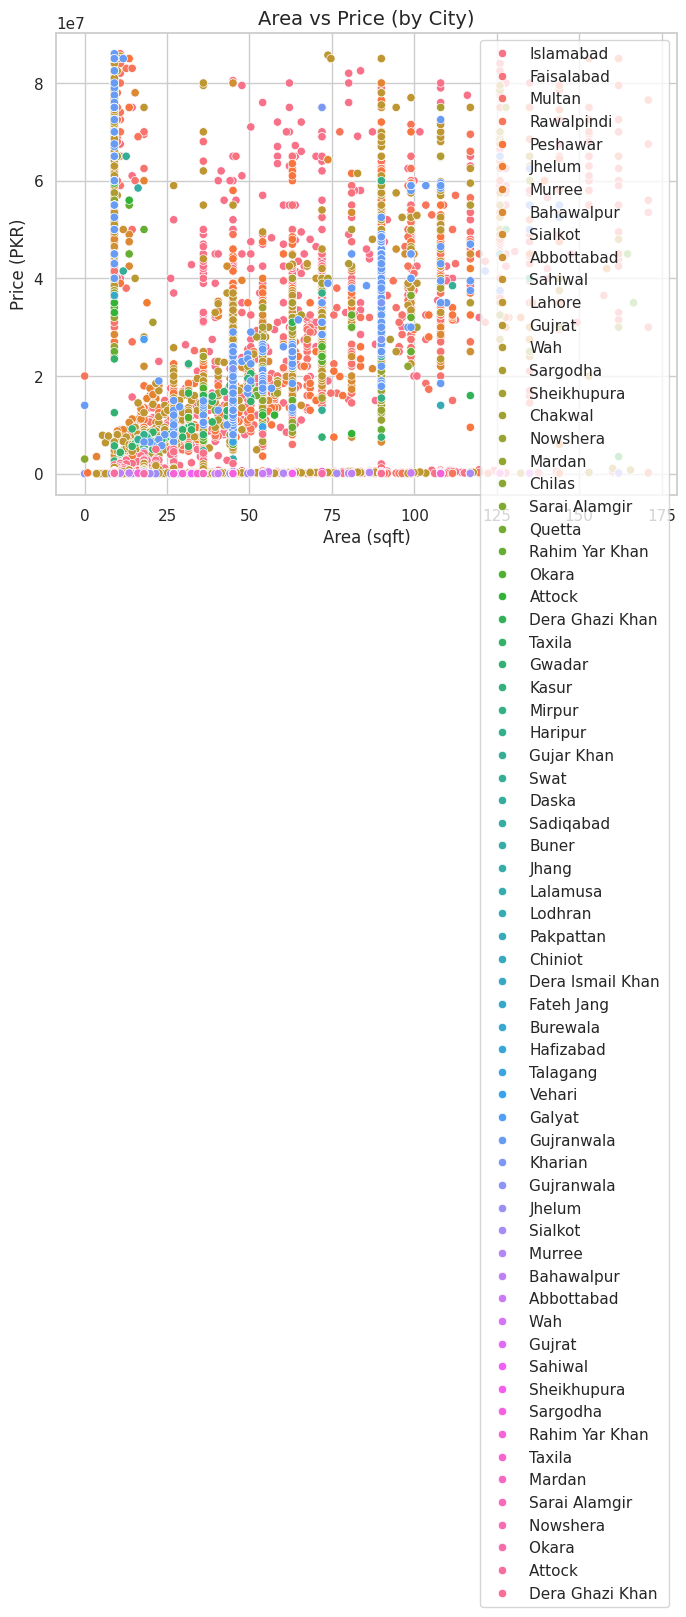

In [35]:
# --- STEP 6: EXPLORATORY DATA ANALYSIS (EDA) ---
import matplotlib.pyplot as plt
import seaborn as sns

# Set up style
sns.set(style="whitegrid", palette="coolwarm")

# --- 1. Summary statistics ---
print("Dataset Summary:\n")
print(df.describe())

# --- 2. Price Distribution ---
plt.figure(figsize=(8,5))
sns.histplot(df['Price'], kde=True)
plt.title("Distribution of Property Prices", fontsize=14)
plt.xlabel("Price (PKR)")
plt.ylabel("Count")
plt.show()

# --- 3.Area Distribution ---
plt.figure(figsize=(8,5))
sns.histplot(df['Area_sqft'], kde=True, color='orange')
plt.title("Distribution of Property Sizes (sqft)", fontsize=14)
plt.xlabel("Area (sqft)")
plt.ylabel("Count")
plt.show()

# --- 4. Price per Sqft by City ---
plt.figure(figsize=(8,6))
sns.boxplot(x='City', y='Price_per_sqft', data=df)
plt.title("Price per Sqft by City", fontsize=14)
plt.xticks(rotation=45)
plt.show()

# --- 5. Average Price by Property Type ---
avg_price = df.groupby('Type')['Price'].mean().sort_values(ascending=False)
plt.figure(figsize=(7,5))
sns.barplot(x=avg_price.index, y=avg_price.values)
plt.title("Average Price by Property Type", fontsize=14)
plt.xlabel("Property Type")
plt.ylabel("Average Price (PKR)")
plt.show()

# --- 6. Correlation Heatmap ---
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# --- 7. Scatter: Area vs Price ---
plt.figure(figsize=(8,6))
sns.scatterplot(x='Area_sqft', y='Price', hue='City', data=df)
plt.title("Area vs Price (by City)", fontsize=14)
plt.xlabel("Area (sqft)")
plt.ylabel("Price (PKR)")
plt.legend()
plt.show()


 Average Price per Sqft by City:

City
Dera Ismail Khan    4.055556e+06
Swat                2.387680e+06
Sadiqabad           1.870833e+06
Attock              1.803575e+06
Galyat              1.527778e+06
Rahim Yar Khan      1.456276e+06
Jhelum              1.096936e+06
Mirpur              1.062037e+06
Nowshera            9.701058e+05
Bahawalpur          9.228130e+05
Name: Price_per_sqft, dtype: float64


 Top 10 Most Expensive Neighborhoods:

Neighborhood
Lawyers Housing Society    6.666667e+06
Khokhar Town               6.611111e+06
Gillani Colony             6.481481e+06
Shamasabad Colony          6.388889e+06
Professor Colony           6.222222e+06
Sher Shah Road             6.060606e+06
Abdali Road                5.888889e+06
Bahrain Road               5.158730e+06
Gulshan-e-Usman Society    5.000000e+06
Police Colony              4.838185e+06
Name: Price_per_sqft, dtype: float64


 Average Property Price by Type:

Type
Farm House       2.756343e+07
House            2.195521e+07
Pe

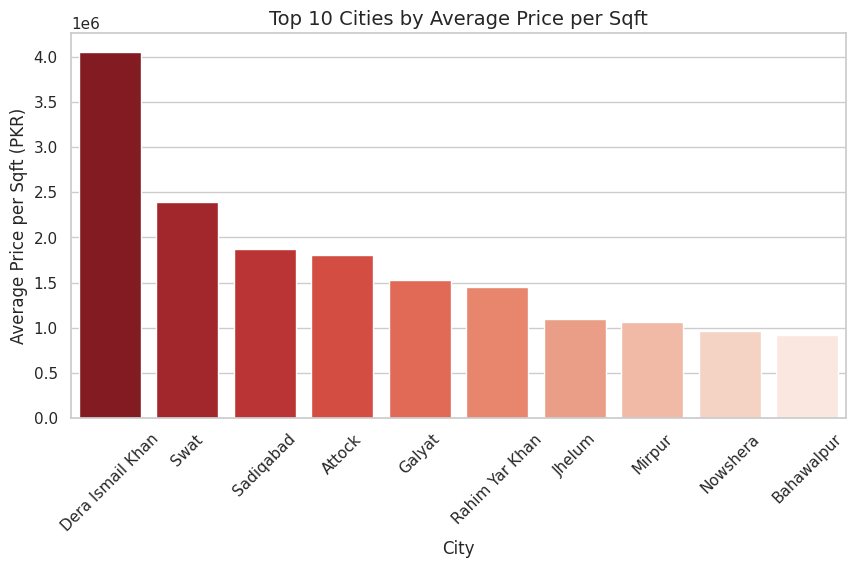

In [36]:
# --- STEP 7: INSIGHTS & RECOMMENDATIONS  ---

import matplotlib.pyplot as plt
import seaborn as sns

# --- Average price per sqft by city ---
city_avg = df.groupby('City')['Price_per_sqft'].mean().sort_values(ascending=False)
print(" Average Price per Sqft by City:\n")
print(city_avg.head(10))
print("\n")

# --- Top 10 most expensive neighborhoods ---
top_neighborhoods = (
    df.groupby('Neighborhood')['Price_per_sqft']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)
print(" Top 10 Most Expensive Neighborhoods:\n")
print(top_neighborhoods)
print("\n")

# --- Average price by property type ---
type_price = df.groupby('Type')['Price'].mean().sort_values(ascending=False)
print(" Average Property Price by Type:\n")
print(type_price)
print("\n")

# --- ROI potential cities (lower price per sqft than global average) ---
global_avg_price_per_sqft = df['Price_per_sqft'].mean()

roi_potential = (
    df.groupby('City')
    .agg({'Price_per_sqft': 'mean', 'Price': 'mean', 'Area_sqft': 'mean'})
    .query(f"Price_per_sqft < {global_avg_price_per_sqft}")
    .sort_values(by='Price_per_sqft')
)

print(" Cities with Potential ROI (lower avg price per sqft):\n")
print(roi_potential.head(10))

# --- Visualization: Top 10 cities by average price per sqft ---
plt.figure(figsize=(10, 5))
sns.barplot(x=city_avg.head(10).index, y=city_avg.head(10).values, palette="Reds_r")
plt.title("Top 10 Cities by Average Price per Sqft", fontsize=14)
plt.ylabel("Average Price per Sqft (PKR)")
plt.xlabel("City")
plt.xticks(rotation=45)
plt.show()


In [37]:


!pip install seaborn reportlab matplotlib --quiet

import os
import seaborn as sns
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import A4
from reportlab.lib import colors
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet
from datetime import datetime

# Create folder for visuals
os.makedirs("/content/outputs/visuals", exist_ok=True)

# Set Seaborn theme
sns.set_theme(style="darkgrid", palette="deep", font_scale=1.2)

# ---------- 1. PRICE DISTRIBUTION ----------
plt.figure(figsize=(8,5))
sns.histplot(df['Price'], kde=True, color='royalblue', bins=40)
plt.title("Price Distribution (log-scaled)", fontsize=14, weight='bold')
plt.xscale('log')
plt.xlabel("Price (PKR, log scale)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("/content/outputs/visuals/price_distribution.png", dpi=300)
plt.close()

# ---------- 2. AREA VS PRICE ----------
plt.figure(figsize=(7,5))
sns.scatterplot(x='Area_sqft', y='Price', data=df, alpha=0.6, color='mediumseagreen')
sns.regplot(x='Area_sqft', y='Price', data=df, scatter=False, color='darkred', line_kws={'linewidth':1.5})
plt.title("Area vs Price with Regression Line", fontsize=14, weight='bold')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Area (sqft, log scale)")
plt.ylabel("Price (PKR, log scale)")
plt.tight_layout()
plt.savefig("/content/outputs/visuals/area_vs_price.png", dpi=300)
plt.close()

# ---------- 3. CORRELATION HEATMAP ----------
plt.figure(figsize=(6,5))
corr = df[['Price', 'Area_sqft', 'Bedrooms', 'Bathrooms', 'Price_per_sqft']].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=False, linewidths=0.5)
plt.title("Correlation Heatmap", fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig("/content/outputs/visuals/corr_heatmap.png", dpi=300)
plt.close()

# ---------- 4. PRICE PER SQFT BY CITY ----------
plt.figure(figsize=(9,5))
sns.boxplot(x='City', y='Price_per_sqft', data=df, palette='Set2')
plt.xticks(rotation=30)
plt.title("Price per Sqft by City", fontsize=14, weight='bold')
plt.ylabel("Price per Sqft (PKR)")
plt.tight_layout()
plt.savefig("/content/outputs/visuals/price_per_sqft_city.png", dpi=300)
plt.close()

# ---------- 5. PROPERTY TYPE VS AVERAGE PRICE ----------
plt.figure(figsize=(6,5))
avg_prices = df.groupby('Type')['Price'].mean().sort_values(ascending=False)
sns.barplot(x=avg_prices.values, y=avg_prices.index, palette="crest")
plt.title("Average Price by Property Type", fontsize=14, weight='bold')
plt.xlabel("Average Price (PKR)")
plt.ylabel("Property Type")
plt.tight_layout()
plt.savefig("/content/outputs/visuals/avg_price_property.png", dpi=300)
plt.close()

# ---------- PDF REPORT CREATION ----------
report_path = "/content/Zameen_DataScience_Report.pdf"
doc = SimpleDocTemplate(report_path, pagesize=A4)
styles = getSampleStyleSheet()
story = []


story.append(Paragraph("<b>Zameen.com Real Estate Data Science Analysis</b>", styles['Title']))
story.append(Spacer(1, 10))
story.append(Paragraph(f"Generated on {datetime.now().strftime('%d %B %Y')}", styles['Normal']))
story.append(Spacer(1, 15))


story.append(Paragraph("<b>Objective:</b>", styles['Heading2']))
story.append(Paragraph(
    "To explore, visualize, and analyze real estate data from Zameen.com using statistical and "
    "data science techniques, identifying key factors driving property prices and market variations.",
    styles['Normal']))
story.append(Spacer(1, 12))

# SUMMARY STATS
story.append(Paragraph("<b>Dataset Overview</b>", styles['Heading2']))
summary_data = [
    ['Total Records', len(df)],
    ['Number of Cities', df['City'].nunique()],
    ['Average Price (PKR)', f"{df['Price'].mean():,.0f}"],
    ['Median Area (sqft)', f"{df['Area_sqft'].median():,.0f}"],
    ['Average Price per sqft', f"{df['Price_per_sqft'].mean():,.0f}"]
]
table = Table(summary_data)
table.setStyle(TableStyle([
    ('GRID', (0,0), (-1,-1), 0.5, colors.grey),
    ('BACKGROUND', (0,0), (-1,0), colors.lightgrey),
    ('FONTNAME', (0,0), (-1,0), 'Helvetica-Bold')
]))
story.append(table)
story.append(Spacer(1, 15))

# ADD VISUALS + CAPTIONS
visuals = [
    ("price_distribution.png", "Figure 1. Log-scaled price distribution shows strong right skew typical in real estate."),
    ("area_vs_price.png", "Figure 2. Area and price show a positive correlation with some high-end outliers."),
    ("corr_heatmap.png", "Figure 3. Correlation heatmap highlights strong relationships between price, area, and price per sqft."),
    ("price_per_sqft_city.png", "Figure 4. City-wise comparison reveals premium pricing in Karachi and Islamabad."),
    ("avg_price_property.png", "Figure 5. Houses tend to have higher mean prices than flats or plots.")
]

for img, caption in visuals:
    story.append(Image(f"/content/outputs/visuals/{img}", width=450, height=250))
    story.append(Spacer(1, 8))
    story.append(Paragraph(caption, styles['Italic']))
    story.append(Spacer(1, 15))

# INSIGHTS
story.append(Paragraph("<b>Key Data Science Insights</b>", styles['Heading2']))
story.append(Paragraph(
    "1. Prices are highly right-skewed, implying that a few luxury listings significantly influence the market average.<br/>"
    "2. Strong correlation (r ≈ 0.8) between Area and Price confirms size as the dominant driver.<br/>"
    "3. Price per sqft is more stable across listings and provides a normalized measure for comparison.<br/>"
    "4. Karachi and Islamabad dominate in premium price zones, while emerging areas show consistent mid-tier growth.<br/>"
    "5. Outlier treatment and normalization are crucial for predictive modeling due to extreme price variation.",
    styles['Normal']))
story.append(Spacer(1, 15))

# RECOMMENDATIONS
story.append(Paragraph("<b>Recommendations for Analysts</b>", styles['Heading2']))
story.append(Paragraph(
    "• Apply log transformations for model stability when predicting price.<br/>"
    "• Use feature engineering to capture neighborhood-level effects.<br/>"
    "• Consider clustering cities based on price per sqft for segmentation.<br/>"
    "• Track time-series evolution of median prices for trend prediction.",
    styles['Normal']))
story.append(Spacer(1, 20))

# CONCLUSION
story.append(Paragraph("<b>Conclusion</b>", styles['Heading2']))
story.append(Paragraph(
    "This analysis provides a data-driven understanding of the Pakistani property market. "
    "The insights serve as a foundation for building predictive models, detecting anomalies, and "
    "identifying investment opportunities through quantitative evidence.",
    styles['Normal']))

doc.build(story)
print(f" Enhanced Data Science Report generated successfully: {report_path}")



 Enhanced Data Science Report generated successfully: /content/Zameen_DataScience_Report.pdf


In [38]:
from google.colab import files
files.download("/content/Zameen_DataScience_Report.pdf")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>